In [2]:
from gradoptorch import gradoptorch

import torch

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import numpy as np

## Define the Rosenbrock function to test optimizers

In [3]:
dim = 2

torch.manual_seed(10)

# Define test objective function
def f(x):
    a = 1.0
    b = 100.0
    return (a - x[0]).pow(2) + b * (x[1] - x[0].pow(2)).pow(2)

# Define gradient objective function
def g(x):
    a = 1.0
    b = 100.0
    xdot = -2*(a-x[0]) - 2*x[0]*b*(x[1]-x[0].pow(2))
    ydot = 2*b*(x[1] - x[0].pow(2))

    return torch.tensor([[xdot], [ydot]])

# Define hessian of objective (note: only required for exact Newton)
def H(x):
    b = 100.0
    H11 = -8*b*(x[1]-x[0].pow(2)) + 8*b*x[0].pow(2) + 2
    H12 = -4*b*x[0]
    H22 = 2*b

    return torch.tensor([[H11, H12], [H12, H22]])

# Rosenbrock function has its minimum at [1,1] for a = 1, b = 100
x_true = torch.tensor([[1.0], [1.0]])

## Define Line-search parameters

In [4]:
x_0 = torch.tensor([[-0.5], [3.0]])

ls_params = {
    'alf': torch.tensor([[0.9]]),
    'rho': torch.tensor([[0.5]]),
    'mu': torch.tensor([[1e-4]]),
    'iter_lim': 1000,
    'alf_lower_coeff': 0.1,
    'alf_upper_coeff': 2.0
}

ls_method = 'back_tracking'


## Setting optimizer parameters

In [5]:
ep_g = 1e-6
ep_a = 1e-6
ep_r = 1e-2
iter_lim = 1000

## Running optimizers

In [6]:
# Example exact gradient
opt_params = {
    'ep_g': ep_g,
    'ep_a': ep_a,
    'ep_r': ep_r,
    'iter_lim': iter_lim
}
x_opt, f_opt, x_hist_gr_exact, f_hist_gr_exact, converge, message = gradoptorch(
    f, g, x_0, opt_method='grad_exact', opt_params=opt_params, ls_method=ls_method, ls_params=ls_params)
print(message)

# Conjugate gradient methods
opt_params = {
    'ep_g': ep_g,
    'ep_a': ep_a,
    'ep_r': ep_r,
    'iter_lim': iter_lim,
    'restart_iter': dim
}
## FR Conjugate Grad.
x_opt, f_opt, x_hist_fr, f_hist_fr, converge, message = gradoptorch(
    f, g, x_0, opt_method='conj_grad_fr', opt_params=opt_params, ls_method=ls_method, ls_params=ls_params)
print(message)

## PR Conjugate Grad. # Not working as expected, may need to update later
x_opt, f_opt, x_hist_pr, f_hist_pr, converge, message = gradoptorch(
    f, g, x_0, opt_method='conj_grad_pr', opt_params=opt_params, ls_method=ls_method, ls_params=ls_params)
print(message)

# Newton's Method
opt_params = {
    'ep_g': ep_g,
    'ep_a': ep_a,
    'ep_r': ep_r,
    'Hessian': H,
    'iter_lim': iter_lim,
}
x_opt, f_opt, x_hist_ne, f_hist_ne, converge, message = gradoptorch(
    f, g, x_0, opt_method='newton_exact', opt_params=opt_params, ls_method=ls_method, ls_params=ls_params)
print(message)

# BFGS
x_opt, f_opt, x_hist_bfgs, f_hist_bfgs, converge, message = gradoptorch(
    f, g, x_0, opt_method='bfgs', opt_params=opt_params, ls_method=ls_method, ls_params=ls_params)
print(message)

Exact gradient converged due to abs. rel. tolerance.
FR conjugate gradient converged due to abs. rel. tolerance.
Back-tracking line search iteration limit reached.
Exact Newton converged due to abs. rel. tolerance.
BFGS converged due to abs. rel. tolerance.


## Plotting optimizer results
Note: performance for all optimizers will improve / worsen with different choices for optimizer parameters. This is simply an example.

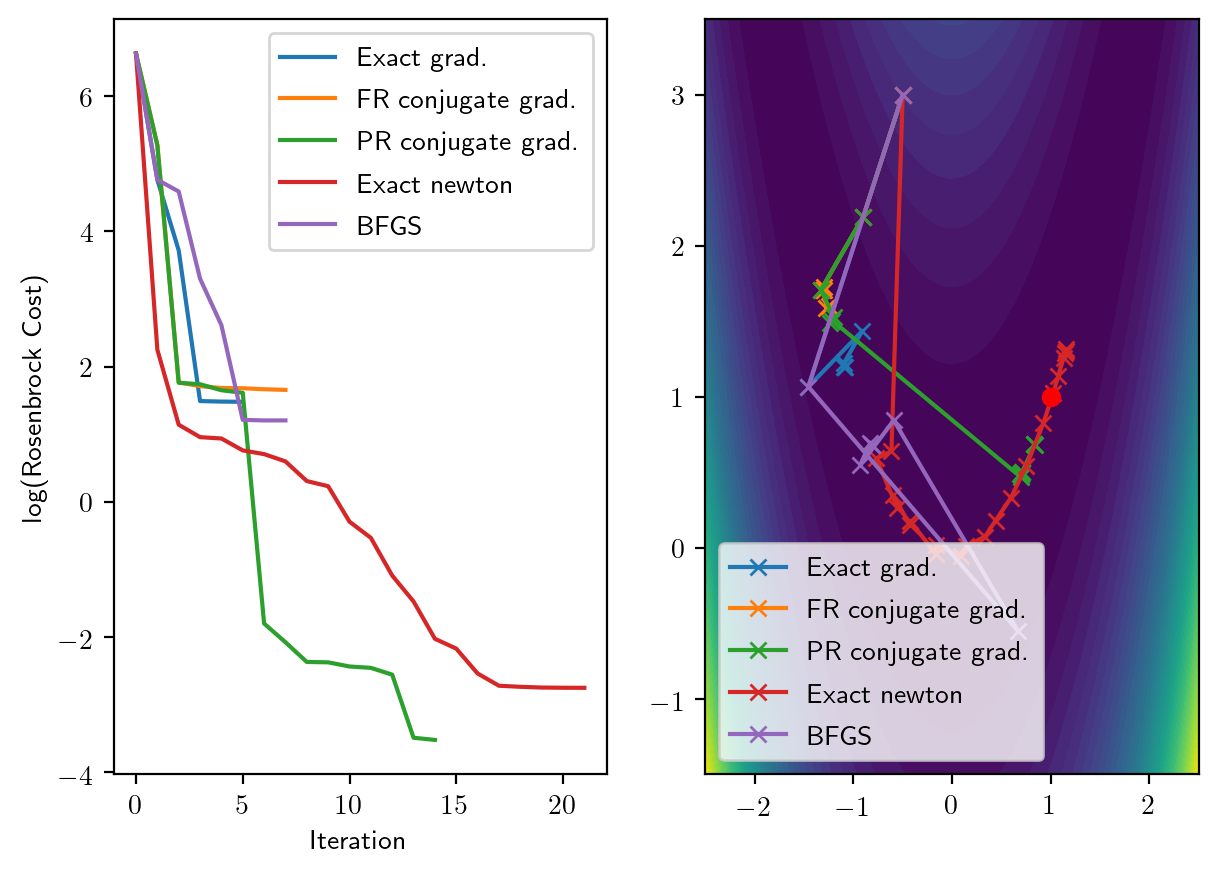

In [9]:
fig = plt.figure(figsize=(7, 5), dpi= 200, facecolor='w', edgecolor='k')
gs = GridSpec(1, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# plotting convergence rates
ax1.plot(torch.log(torch.tensor(f_hist_gr_exact)))
ax1.plot(torch.log(torch.tensor(f_hist_fr)))
ax1.plot(torch.log(torch.tensor(f_hist_pr)))
ax1.plot(torch.log(torch.tensor(f_hist_ne)))
ax1.plot(torch.log(torch.tensor(f_hist_bfgs)))
ax1.set_xlabel('Iteration')
ax1.set_ylabel('log(Rosenbrock Cost)')
ax1.legend(['Exact grad.', 'FR conjugate grad.','PR conjugate grad.', 'Exact newton', 'BFGS'])

# plotting Rosenbrock
X, Y = torch.meshgrid(torch.linspace(-2.5, 2.5), torch.linspace(-1.5, 3.5))
Z = torch.zeros(size=X.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        tmp = torch.tensor([X[i, j], Y[i, j]])
        Z[i, j] = f(tmp)

surf = ax2.contourf(X.numpy(), Y.numpy(), Z.numpy(), 50)

x_hist_gr_exact = np.array([[X[0], X[1]] for X in x_hist_gr_exact])
x_hist_fr = np.array([[X[0], X[1]] for X in x_hist_fr])
x_hist_pr = np.array([[X[0], X[1]] for X in x_hist_pr])
x_hist_ne = np.array([[X[0], X[1]] for X in x_hist_ne])
x_hist_bfgs = np.array([[X[0], X[1]] for X in x_hist_bfgs])

ax2.plot(x_hist_gr_exact[:, 0], x_hist_gr_exact[:, 1], 'x-')
ax2.plot(x_hist_fr[:, 0], x_hist_fr[:, 1], 'x-')
ax2.plot(x_hist_pr[:, 0], x_hist_pr[:, 1], 'x-')
ax2.plot(x_hist_ne[:, 0], x_hist_ne[:, 1], 'x-')
ax2.plot(x_hist_bfgs[:, 0], x_hist_bfgs[:, 1], 'x-')
ax2.legend(['Exact grad.', 'FR conjugate grad.','PR conjugate grad.', 'Exact newton', 'BFGS'])
ax2.plot(1, 1, 'ro')

plt.show()